# Entrenamiento y Evaluación del Modelo Predictivo

**Autor:** [Eduardo José Limones Contreras]

---

## 1. Búsqueda y Optimización del Mejor Modelo

En esta sección, se detalla la metodología utilizada para encontrar el modelo más performante.

Se ha optado por una estrategia de búsqueda competitiva entre tres de los algoritmos de ensamble más potentes para datos tabulares: **RandomForest**, **XGBoost** y **LightGBM**. Para explorar de manera eficiente el espacio de hiperparámetros de cada modelo, se utilizará la técnica de **RandomizedSearchCV**, que permite evaluar un número predefinido de combinaciones aleatorias, ofreciendo un excelente equilibrio entre rendimiento y coste computacional.

El criterio principal para la selección del mejor modelo durante la búsqueda será el **coeficiente de determinación (R²)**. Esta métrica ha sido seleccionada por su capacidad para medir la proporción de la varianza de la variable objetivo (salario) que es explicada por el modelo, lo cual es un indicador clave de la bondad de ajuste en problemas de regresión.


## 2. Evaluación del Modelo Ganador

Una vez identificado el modelo campeón y sus hiperparámetros óptimos, se procede a una evaluación final y definitiva sobre el conjunto de prueba (`test.csv`), que fue aislado al inicio del proceso y no ha sido utilizado en ninguna fase del entrenamiento.


El modelo final, un `RandomForestRegressor`, ha demostrado un alto poder predictivo, explicando un **87.7%** de la varianza de los salarios en el conjunto de prueba. El MAE de **10.796,61** indica que, en promedio, las predicciones del modelo se desvían esta cantidad del salario real, un resultado notablemente preciso dado el amplio rango de salarios. 

---

In [2]:
# IMPORTACIÓN DE LIBRERÍAS
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('salarios_codificado.csv')

In [ ]:
# Separamos en train y test para tener mas resultados para probar
train, test = train_test_split(df, test_size = 0.20, random_state = 42)
train.to_csv('train.csv', index=False) #Guardo el DataFrame como train.csv
test.to_csv('test.csv', index=False) #Guardo el DataFrame como test.csv

In [ ]:
train = pd.read_csv('train.csv')
X = train.drop('salary_EUR', axis=1)
y = train['salary_EUR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
## Búsqueda y Optimización del Mejor Modelo

pipe = Pipeline([
    ('regresor', XGBRegressor(random_state=42))
])

# Parámetros para los 3 competidores
param_dist = [
    {'regresor': [XGBRegressor(random_state=42)], 'regresor__n_estimators': randint(100, 500), 'regresor__max_depth': randint(3, 10), 'regresor__learning_rate': uniform(0.01, 0.2)},
    {'regresor': [LGBMRegressor(random_state=42)], 'regresor__n_estimators': randint(100, 500), 'regresor__num_leaves': randint(20, 60)},
    {'regresor': [RandomForestRegressor(random_state=42)], 'regresor__n_estimators': randint(100, 500), 'regresor__max_depth': randint(5, 25)}
]


# Configurar y Ejecutar la Búsqueda
random_search = RandomizedSearchCV(
    pipe, param_distributions=param_dist,
    n_iter=75, # Probamos 75 combinaciones para una buena búsqueda
    cv=5,
    scoring='r2', 
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

# Evaluación del Modelo Ganador
modelo_ganador = random_search.best_estimator_
predicciones = modelo_ganador.predict(X_test)
r2_final = r2_score(y_test, predicciones)
mae_final = mean_absolute_error(y_test, predicciones)

# Resultados Finales
print(f"El score R² final es: {r2_final:.4f}")
print(f"El Error Absoluto Medio (MAE) final es: {mae_final:,.2f} EUR")
print("\nEl mejor modelo y sus parámetros son:")
print(random_search.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
El score R² final es: 0.8773
El Error Absoluto Medio (MAE) final es: 10,796.61 EUR

El mejor modelo y sus parámetros son:
{'regresor': RandomForestRegressor(random_state=42), 'regresor__max_depth': 7, 'regresor__n_estimators': 305}


In [ ]:
# Guardamos y cargamos el modelo para poder usarlo sin repetir la búsqueda
with open('mi_modelo_salarios.pkl', 'wb') as file:
    pickle.dump(modelo_ganador, file)


In [3]:
with open('mi_modelo_salarios.pkl', 'rb') as file:
     modelo_cargado = pickle.load(file)

In [ ]:
# Volvemos a probar el modelo con los datos que habiamos separado anteriormente

df_test = pd.read_csv('test.csv')

X_test_nuevo = df_test.drop(columns=['salary_EUR'])
y_test_real = df_test['salary_EUR']

predicciones_nuevas = modelo_cargado.predict(X_test_nuevo)

df_resultados = pd.DataFrame({'Salario_Predicho_EUR': predicciones_nuevas})    

r2 = r2_score(y_test_real, predicciones_nuevas)
mae = mean_absolute_error(y_test_real, predicciones_nuevas)
print("Evaluación en 'test.csv'")
print(f"El score R² en este set es: {r2:.4f}")
print(f"El MAE en este set es: {mae:,.2f} EUR")

Evaluación en 'test.csv'
El score R² en este set es: 0.8456
El MAE en este set es: 12,377.89 EUR


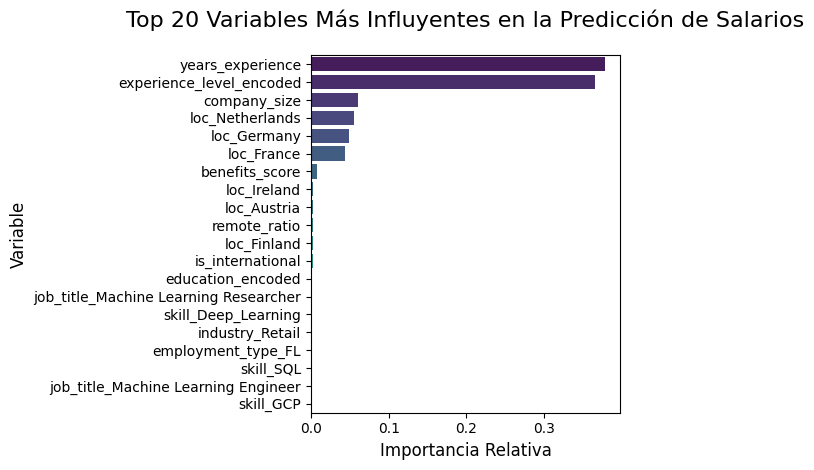

In [ ]:
# Vamos a ver el grafico de las caracteristicas mas importantes para nuestro modelo

# Extraer el modelo RandomForest del Pipeline
modelo_final = pipeline_cargado.named_steps['regresor']

# Extraer y procesar la importancia de las variables del modelo extraído
importances = modelo_final.feature_importances_
feature_names = X_train.columns

# Crear un DataFrame para facilitar la manipulación y el ordenamiento
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Tomar las 20 características más importantes para una mejor visualización
top_20_features = feature_importance_df.head(20)

sns.barplot(x='importance', y='feature', data=top_20_features, palette='viridis', hue='feature', legend=False)
plt.title('Top 20 Variables Más Influyentes en la Predicción de Salarios', fontsize=16, pad=20)
plt.xlabel('Importancia Relativa', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.tight_layout()


plt.savefig('feature_importance.png')
plt.show()